# PASOS PARA REALIZAR UN MODELO ARIMA

1. Preparación de datos:
2. Comprobar si la serie es estacionaria:
3. División de datos:
4. Construcción del modelo ARIMA:
5. Realización de la predicción:
6. Visualización de la predicción:

## Importar librerías necesarias

In [44]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from statsmodels.tsa.arima_model import ARIMA
# from pmdarima import ARIMA

## 1. Preparación de los datos

* Importar los datos
* Asegurar que existe una columna 'FECHA' y una columna 'ICA'
* Asegurar que la columna 'FECHA' tiene formato datetime
* Establecer la fecha como índice del dataframe

In [45]:
df = pd.read_csv('../data/calidad_aire_clean_outliers.csv', delimiter=',')
df = df[['FECHA', 'ICA']]
df["FECHA"] = pd.to_datetime(df["FECHA"], format="%Y-%m-%d %H:%M:%S")
df.set_index("FECHA", inplace = True)
df.dropna(inplace = True, axis = "rows")
df.head(2)

,ICA
FECHA,
2019-01-01 05:00:00,45.22
2019-01-01 06:00:00,45.64


##### Comprobar si hay valores faltantes

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30860 entries, 2019-01-01 05:00:00 to 2023-05-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ICA     30860 non-null  float64
dtypes: float64(1)
memory usage: 482.2 KB


## 2. Comprobar si la serie es estacionaria

#### 2.1. Visualización: Análisis exploratorio de datos (EDA)
* Separar x y la y para el gráfico
* Visualización de los datos anteriores a los largo de los años

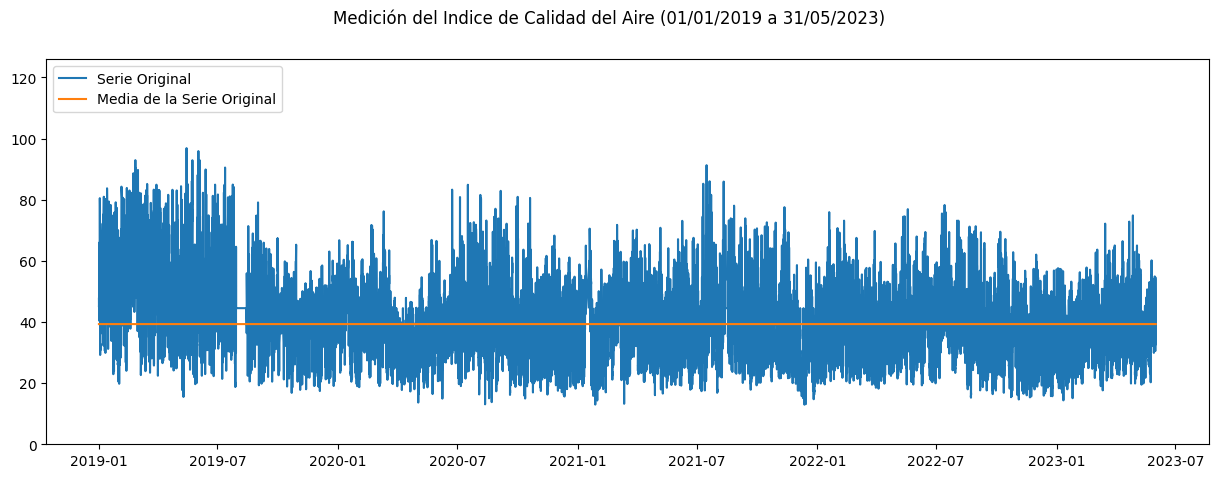

In [71]:
x = df.index
y = df["ICA"]
y_media = [np.mean(y) for _ in y]

# visualización de los datos anteriores a los largo de los años
fig = plt.figure(figsize = (15, 5))
ax = fig.subplots(1, 1)

ax.plot(x, y, label = "Serie Original")
ax.plot(x, y_media, label = "Media de la Serie Original")
ax.set_ylim(0, np.max(y)*1.3)
ax.legend(loc = "upper left")
fig.suptitle("Medición del Indice de Calidad del Aire (01/01/2019 a 31/05/2023)");

    CONCLUSION:

    Observando las gráficas podemos concluir que la serie original parece ser estacionaria si nos fijamos en su comportamiento, ya que la media es la misma en tramos diferentes de la serie, por tanto, no es necesario hacer ninguna transformación. 

#### 2.2. Prueba estadística ADF: Comprobación de la estacionaridad de la serie 

* El objetivo de la prueba ADF es evaluar la presencia de una raíz unitaria en una serie temporal, lo que indica la presencia de tendencia y no  
  estacionariedad.

* La hipótesis nula (H0) de la prueba ADF es que la serie temporal tiene una raíz unitaria, lo que significa que es no estacionaria. 

* La hipótesis alternativa (H1) es que la serie no tiene una raíz unitaria y, por lo tanto, es estacionaria.

* El estadístico ADF se calcula comparando la tasa de cambio en los valores de la serie temporal con su propia variación aleatoria:
  - Si el estadístico ADF es menor que el valor crítico (umbral), se rechaza la hipótesis nula y se concluye que la serie es estacionaria. 
  - Si el estadístico ADF es mayor que el valor crítico, no se puede rechazar la hipótesis nula y se concluye que la serie es no estacionaria.

In [48]:
for serie, nombre_serie in zip([y], ["Serie Original"]):    
    resultado_analisis = adfuller(serie)
    
    valor_estadistico_adf = resultado_analisis[0]
    p_valor = resultado_analisis[1]
    
    print("Valor estadístico de ADF: {}".format(-2.89))
    print("Valor Crítico: {}\n".format(valor_estadistico_adf))
    
    print("Nivel de significación: {}".format(0.05))
    print("p-valor: {}\n".format(p_valor))

Valor estadístico de ADF: -2.89
Valor Crítico: -13.69138297075373

Nivel de significación: 0.05
p-valor: 1.341913606188679e-25



      * ADF: Decisión a partir del resultado obtenido:

      1. Observamos p-valor < nivel significación, es decir, el estadístico ADF es menor
         que el valor crítico. 
      2. Por tanto, rechazamos la hipótesis nula (H0). 
      3. Conclusión:
            * LA SERIE ES ESTACIONARIA

#### 2.3.  Analizar autocorrelación y autocorrelación parcial

* LAGS: Desfases o rezagos en una serie temporal. Representan la diferencia de tiempo entre una observación y otra. 
  Por ejemplo, un lag de 1 indica la correlación entre una observación y la observación inmediatamente anterior.

* ACF (Autocorrelación): La función de autocorrelación (ACF, por sus siglas en inglés) es una medida de la correlación entre una observación 
  y sus valores rezagados a diferentes intervalos de tiempo. Representa cómo se correlaciona una serie consigo misma a medida que se desplaza en el tiempo. La ACF se utiliza para identificar patrones de correlación en una serie temporal.

* PACF (Autocorrelación parcial): La función de autocorrelación parcial (PACF, por sus siglas en inglés) mide la correlación directa entre una 
  observación y sus valores rezagados, eliminando la influencia de los valores intermedios. La PACF ayuda a determinar la correlación directa entre una observación y su rezago específico, ignorando las correlaciones indirectas.

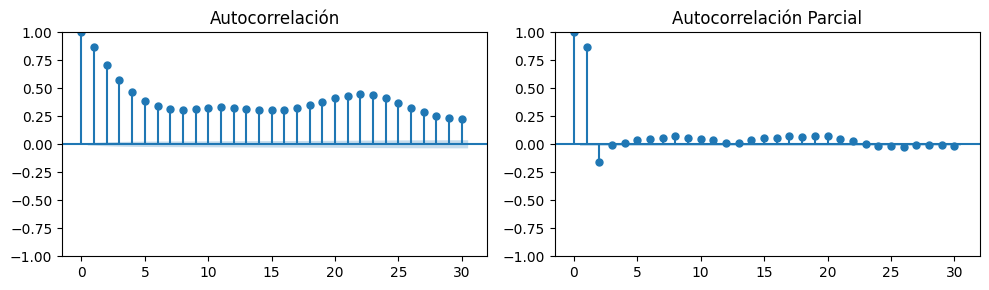

In [49]:
LAGS = 30

fig = plt.figure(figsize = (10, 3))
(ax1, ax2) = fig.subplots(1, 2)

# Gráfico de ACF(autocorrelación) y PACF(Autocorrelación Parcial)
plot_acf(y, ax = ax1, lags = LAGS, title = "Autocorrelación")
plot_pacf(y, ax = ax2, lags = LAGS, title = "Autocorrelación Parcial")

fig.tight_layout()

## 3. División de datos

* train: Entrenamiento
* test: Prueba

In [50]:
serie_a_predecir = y

# Predecir valor del ICA en los próximos 30 días
y_train = df[:-168]
y_test = df[-168:]

print(y_train.head())
print(y_test.head())

                       ICA
FECHA                     
2019-01-01 05:00:00  45.22
2019-01-01 06:00:00  45.64
2019-01-01 07:00:00  47.94
2019-01-01 08:00:00  47.78
2019-01-01 09:00:00  45.88
                       ICA
FECHA                     
2023-05-23 11:00:00  43.28
2023-05-23 12:00:00  43.82
2023-05-23 13:00:00  43.11
2023-05-23 14:00:00  38.20
2023-05-23 15:00:00  34.49


## 4.  Construcción de Modelo ARIMA

Un modelo ARIMA se repsenta como ARIMA (p, d, q) donde:

* AR (p): representa la parte "Autorregresiva" del modelo. La intuición básica consiste en que los valores pasados más próximos al momento "t", 
  tendrán mayor impacto en los valores presentes. Para determinar el orden "p" del modelo, podemos utilizar el plot de autocorrelación parcial

* I (d): representa la parte "Integral" del modelo y este parámetro del modelo nos dice cuantos diferenciaciones (restas de la serie contra si 
  misma) se tienen que llevar a cabo para convertir la serie en estacionaria.

* MA (q): representa la parte de "Medias Móviles". Como vimos, esto implica que el error del modelo se establece como una combinaciòn lineal de 
  los errores observados en el pasado. Para determinar el orden "q" del modelo, podemos utilizar el plot de autocorrelación.

El modelo básico de ARIMA se puede extender más allá incorporando la estacionalidad de la serie y variables exógenas. En este caso estaríamos hablado del modelo SARIMAX representado por (p, d, q) x (P, D, Q) S: donde los parámetros (P, D, Q) representan la misma idea que los (p, d, q) pero tratan sobre la parte estacional de la serie.

El parámetro S a su vez representa el número de periodos que tienen que pasar para que la estacionalidad se repita: 12 para meses, 4 para trimestres etc.

In [51]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# En caso de querer probar un modelo SARIMAX completo, ejecutar la siguiente línea de itertools.
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Los dejamos a cero para sólo analizar un modelo ARIMA.
seasonal_pdq = [(0, 0, 0, 0)]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 0)
SARIMAX: (0, 1, 0) x (0, 0, 0, 0)


#### 4.1 Gridsearch: Búsqueda de los parámetros óptimos para el modelo ARIMA

A continuación utilizaremos una "Gridsearch" básico para buscar los parámetros óptimos del modelo ARIMA.

* Para hacer el gridsearch, hay que calcular los posibles valores que vamos a pasarle al modelo.

* Utilizamos el modelo SARIMAX, porque en su implementaciòn en Python existen herramientas adicionales  que facilitan el análisis y que
  no están disponibles en la implementación de ARIMA.

* ARIMAX es un modelo ARIMA pero con un componente estacional (la leta S de Seasonal) y también un componente exógeno (X de eXogenous 
  regressors). Por tanto un modelo SARIMAX de (1, 1, 1) x (0, 0, 0, 0). Es un modelo ARIMA (1, 1, 1)   

In [52]:
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # guardamos el mejor resultado
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal   
        # alguna combinación de parámetros en SARIMAX, no son válidos y los vamos a cazar con un except
        except:
            continue

et = time.time()

print("La búsqueda de parámetros no ha llevado {} minutos!".format((et - st)/60))

ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:315167.8669124735
ARIMA(0, 0, 1)x(0, 0, 0, 0)12 - AIC:278273.31316203024
ARIMA(0, 0, 2)x(0, 0, 0, 0)12 - AIC:253580.11736528203
ARIMA(0, 1, 0)x(0, 0, 0, 0)12 - AIC:198816.04248546239
ARIMA(0, 1, 1)x(0, 0, 0, 0)12 - AIC:198601.94013498945
ARIMA(0, 1, 2)x(0, 0, 0, 0)12 - AIC:198473.01167465493
ARIMA(0, 2, 0)x(0, 0, 0, 0)12 - AIC:217621.57953876432
ARIMA(0, 2, 1)x(0, 0, 0, 0)12 - AIC:198816.24102719428
ARIMA(0, 2, 2)x(0, 0, 0, 0)12 - AIC:198602.08525409253
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:198649.79309950228
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:198404.35355966972
ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:198307.06400244153
ARIMA(1, 1, 0)x(0, 0, 0, 0)12 - AIC:198635.26955657185
ARIMA(1, 1, 1)x(0, 0, 0, 0)12 - AIC:198562.14861646053
ARIMA(1, 1, 2)x(0, 0, 0, 0)12 - AIC:195343.366040707
ARIMA(1, 2, 0)x(0, 0, 0, 0)12 - AIC:211657.50903367938
ARIMA(1, 2, 1)x(0, 0, 0, 0)12 - AIC:198635.86846073275
ARIMA(1, 2, 2)x(0, 0, 0, 0)12 - AIC:198562.1672270719
ARIMA(2, 0, 0)

#### 4.2 Elección del mejor modelo ARIMA:

* El índice de AIC es Akaike Information Criterion y sirve para elegir un modelo entre un conjunto de posibles modelos.

* El índice calcula la distancia de Kullback - Leibler entre el modelo y la serie.

* Una forma de interpretar el índice es: buscamos el modelo con el menor índice porque este es el más simple que se ajusta a los datos.

In [53]:
print("El mejor modelo es {}, \nCon un AIC de {}".format(best_params, best_score))

El mejor modelo es (2, 1, 2), 
Con un AIC de 195103.95379637016


#### 4.3 Entrenamiento del modelo ARIMA

In [54]:
# Entrenamos el modelo con los mejores parametros.

model = sm.tsa.statespace.SARIMAX(y_train,
                                order = best_params,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = model.fit()

#### 4.4 Interpretación del mejor modelo

* Coeficientes: Los coeficientes estimados representan los valores estimados para los parámetros del modelo ARIMA. En tu caso, los coeficientes están etiquetados como ar.L1, ar.L2, ma.L1, ma.L2 y sigma2. Estos coeficientes indican la contribución de las observaciones rezagadas (AR) y los errores rezagados (MA) en la predicción de la serie temporal. 

* Errores estándar (std err): Los errores estándar asociados con los coeficientes estimados indican la incertidumbre en las estimaciones de los parámetros del modelo.

* Estadística z y p-valores: Estos valores se utilizan para probar la significancia estadística de los coeficientes. La estadística z es una medida de cuántas desviaciones estándar está el coeficiente del valor nulo. El p-valor indica la probabilidad de obtener una estadística z igual o más extrema que la observada si la hipótesis nula es verdadera. 

* Intervalos de confianza (0.025 y 0.975): Estos intervalos indican el rango de valores dentro del cual se espera que estén los coeficientes con una confianza del 95%. 

* Sigma2: Sigma2 representa la varianza estimada del ruido en el modelo ARIMA. Es un parámetro importante para evaluar la calidad del ajuste del modelo. 

En resumen, los coeficientes estimados y los resultados de la prueba de significancia te proporcionan información sobre cómo las observaciones y los errores rezagados contribuyen a la predicción de la serie temporal. Los p-valores bajos y los intervalos de confianza estrechos indican la importancia y la precisión de los coeficientes. Además, el valor de sigma2 te da una idea de la varianza del ruido en el modelo ajustado.

In [55]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3459      0.020     68.222      0.000       1.307       1.385
ar.L2         -0.5101      0.016    -31.993      0.000      -0.541      -0.479
ma.L1         -1.3794      0.021    -66.265      0.000      -1.420      -1.339
ma.L2          0.4009      0.020     19.608      0.000       0.361       0.441
sigma2        33.7632      0.175    192.622      0.000      33.420      34.107


    La interpretación de coeficientes:

    * ar.L1 y ar.L2 representan los coeficientes de autorregresión (AR) del modelo. 
        En este caso, el coeficiente ar.L1 tiene un valor de 1.3452, lo que indica que hay una fuerte dependencia de la observación actual en la observación anterior. 
        El coeficiente ar.L2 tiene un valor de -0.5095, lo que indica una dependencia negativa de la observación actual en la segunda observación anterior.

    * ma.L1 y ma.L2 representan los coeficientes de media móvil (MA) del modelo. 
        En este caso, el coeficiente ma.L1 tiene un valor de -1.3790, lo que indica una fuerte dependencia de la observación actual en el error de la observación anterior. 
        El coeficiente ma.L2 tiene un valor de 0.4005, lo que indica una dependencia positiva de la observación actual en el error de la segunda observación anterior.

    * sigma2 representa la varianza del ruido blanco en el modelo. 
        En este caso, tiene un valor de 33.7188.

    * p-valores:    
         Al ser muy pequeños (0.000), sugiere que los coeficientes son significativamente diferentes de cero y tienen un impacto significativo en el modelo.

    * Intervalos de confianza: 
        Por ejemplo, para ar.L1, se espera que el valor real del coeficiente esté dentro del rango de 1.307 a 1.384 con un 95% de confianza.


    CONCLUSIÓN: 

    El modelo ARMA(2,2) muestra una dependencia significativa de las observaciones anteriores y de los errores anteriores en la predicción del valor actual. 
    El modelo tiene una varianza de ruido blanco de 33.7188. 

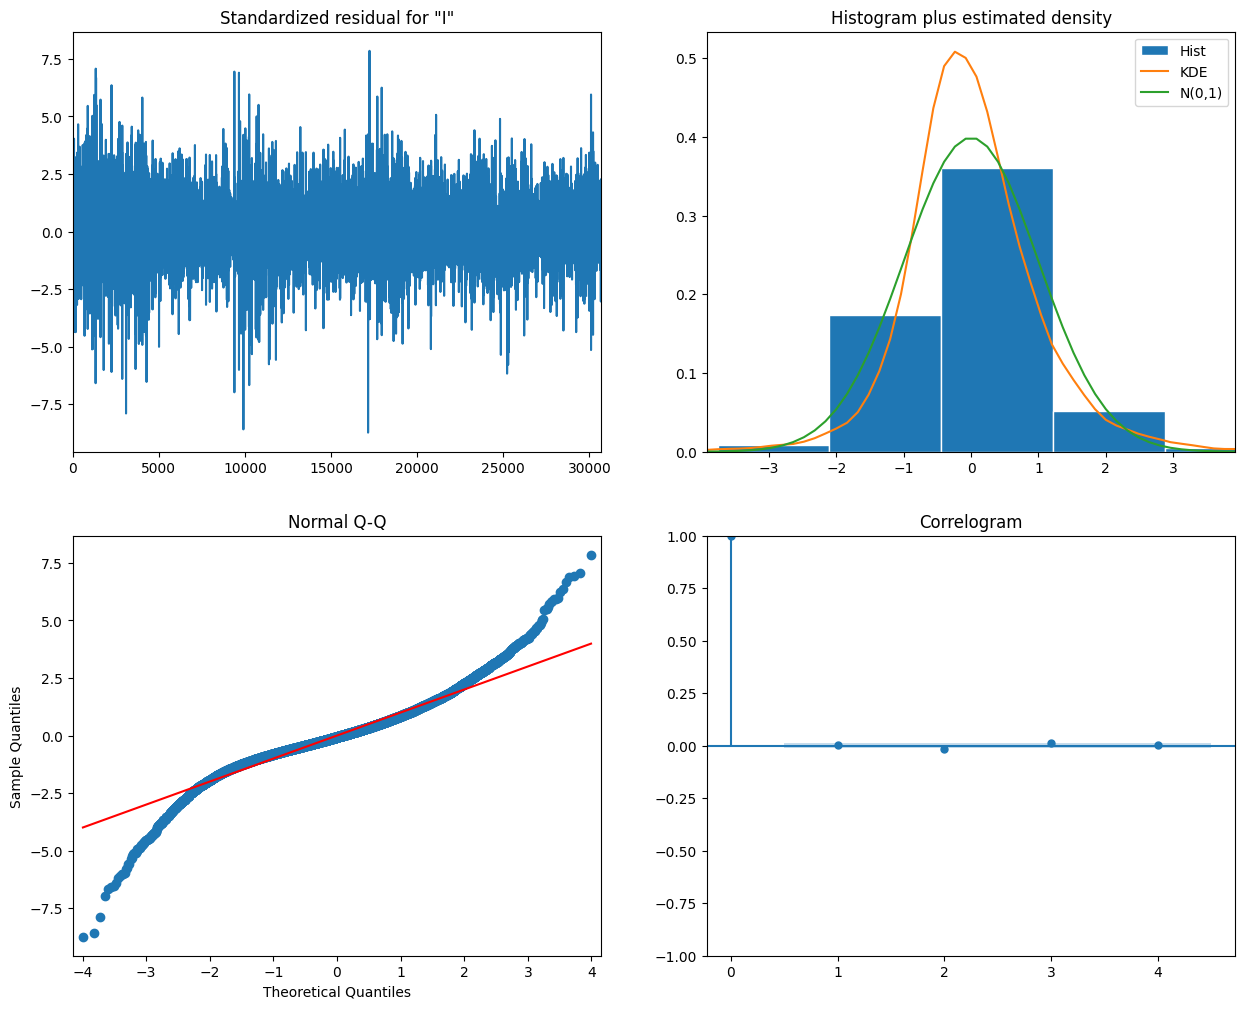

In [111]:
results.plot_diagnostics(figsize = (15, 12), lags = 4);

## 5. Predicción utilizando el modelo

In [92]:
# Obtener predicciones y mostrarlas por consola
predictions = results.predict(start=len(df), end=len(df)+1499)
predictions.head()

30860    36.713335
30861    36.713335
30862    36.713335
30863    36.713335
30864    36.713335
Name: predicted_mean, dtype: float64

In [93]:
forecast = results.get_forecast(steps=1500)
forecast_values = forecast.predicted_mean
forecast_index = pd.date_range(start=df.index[-1], periods=1501, freq='H')[1:]
forecast_index

DatetimeIndex(['2023-06-01 00:00:00', '2023-06-01 01:00:00',
               '2023-06-01 02:00:00', '2023-06-01 03:00:00',
               '2023-06-01 04:00:00', '2023-06-01 05:00:00',
               '2023-06-01 06:00:00', '2023-06-01 07:00:00',
               '2023-06-01 08:00:00', '2023-06-01 09:00:00',
               ...
               '2023-08-02 02:00:00', '2023-08-02 03:00:00',
               '2023-08-02 04:00:00', '2023-08-02 05:00:00',
               '2023-08-02 06:00:00', '2023-08-02 07:00:00',
               '2023-08-02 08:00:00', '2023-08-02 09:00:00',
               '2023-08-02 10:00:00', '2023-08-02 11:00:00'],
              dtype='datetime64[ns]', length=1500, freq='H')

In [94]:
prediction_df = pd.DataFrame({'FECHA': forecast_index, 'Prediccion_ICA': predictions})
prediction_df.set_index('FECHA', inplace=True)

# Ajustar las longitudes de y_test['ICA'] y forecast_values
y_test_adjusted = y_test.iloc[:len(forecast_values)]
prediction_df.head()

,Prediccion_ICA
FECHA,
2023-06-01 00:00:00,36.713335
2023-06-01 01:00:00,36.713335
2023-06-01 02:00:00,36.713335
2023-06-01 03:00:00,36.713335
2023-06-01 04:00:00,36.713335


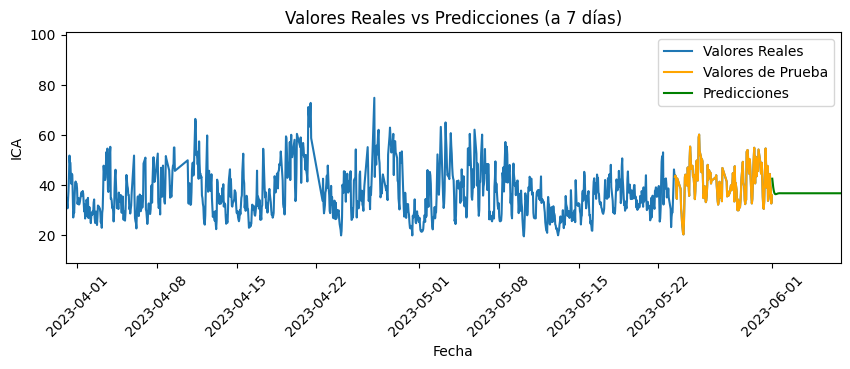

In [110]:
# Dimensionar el gráfico
plt.figure(figsize=(10, 3)) 

# Visualizar en un gráfico los valores reales, los valores de prueba y las predicciones
plt.plot(df.index, df.values, label='Valores Reales')
plt.plot(y_test_adjusted.index, y_test_adjusted['ICA'], color='orange', label='Valores de Prueba')  # Agregar esta línea
plt.plot(forecast_index, forecast_values, color='green', label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('ICA')
plt.xlim(pd.Timestamp('2023-03-31'), pd.Timestamp('2023-06-07'))  # Mostrar solo el periodo de mayo a julio de 2023
plt.xticks(rotation=45)
plt.legend()
plt.title('Valores Reales vs Predicciones (a 7 días)')
plt.show()

## 6. Validación del modelo

In [ ]:
# Ajustar las longitudes de los valores reales y las predicciones
y_true_adjusted = df['ICA'].iloc[-168:]


# Calcular el error cuadrado medio
mse = mean_squared_error(y_true_adjusted, forecast_values)
print('Error cuadrado medio:', mse)

# Calcular el error absoluto medio
mae = mean_absolute_error(y_true_adjusted, forecast_values)
print('Error absoluto medio:', mae)

    CONCLUSIÓN:

    * El error cuadrado medio (MSE) obtenido es de 43.465958831278265, lo que indica que en promedio, las predicciones del modelo difieren en un valor cuadrado de 43.465958831278265 del valor real. 

    * El error absoluto medio (MAE) obtenido es de 5.697280147725101, lo que indica que en promedio, las predicciones del modelo difieren en un valor absoluto de 5.697280147725101 del valor real.

    Estos valores de error nos permiten evaluar la precisión del modelo. En este caso,  el modelo tiene un buen rendimiento en términos de precisión, ya que los errores son relativamente bajos. pero es necesario realizar análisis adicionales para una evaluación más completa del modelo.